In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.argv=[''] 
del sys

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_DEVICES_VISIBLE']='0,1'

In [ ]:
cd "/root/SymmNeRF/"

/root/SymmNeRF


In [5]:
from opt import config_parser

parser = config_parser()
args = parser.parse_args()

device = 'cuda:0'
det = args.det
lindisp = args.lindisp

In [6]:
import lpips
from torch.utils.data import DataLoader
from skimage import metrics
import glob

import opt
from utils.general import *
from datasets import dataset_dict
from model import model_dict
from model.sample_ray import RaySampler
from model.render_ray import render_single_image

import setproctitle
import torch 
import numpy as np 
import cv2
from einops import rearrange 
import matplotlib.pyplot as plt
from tqdm import tqdm 
import imageio
import time

setproctitle.setproctitle('[Gaetan. - SymmNeRF]')

In [7]:
logs_folder = os.path.join('/root/SymmNeRF/logs', args.eval_dataset, args.eval_scene, args.expname)
ckpts_folder = os.path.join(logs_folder, 'ckpts')

In [8]:
model = model_dict[args.model](args, ckpts_folder)
model.switch_to_eval()

[Info] Reloading from /root/SymmNeRF/logs/srns_dataset/cars/srns_cars/ckpts/model_300000.pth, starting at step=300000


In [9]:
scene_name = args.eval_scene
eval_folder = os.path.join(logs_folder, 'eval_' + time.strftime("%m%d", time.localtime()) if not args.eval_approx else 'eval_approx')
out_scene_dir = os.path.join(eval_folder, '{}_{:06d}'.format(scene_name, model.start_step))
print(f'Folders where images are going to be save: {out_scene_dir}')
os.makedirs(out_scene_dir, exist_ok=True)

Folders where images are going to be save: /root/SymmNeRF/logs/srns_dataset/cars/srns_cars/eval_0202/cars_300000


In [9]:
test_dataset = dataset_dict[args.eval_dataset](args, 'test', scene=args.eval_scene)

SRNsDataset:  /data/datasets/srn_cars/cars_test


In [10]:
lpips_vgg = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.8/dist-packages/lpips/weights/v0.1/vgg.pth


In [89]:
def get_n_instance(loader,n):
    it = iter(loader)
    data = []
    for i in range(n):
        data.append(next(it))
    return data
   
def get_an_instance_and_its_ray_sampler(data):
    data = data[np.random.randint(10)]
    ray_sampler = RaySampler(data)
    # Get the list of the view to render. 
    render_list = list(range(ray_sampler.render_imgs[0].shape[0]))
    render_list.remove(ray_sampler.src_view[0])
    render_view = int(np.random.choice(render_list ,1)) # int() for toy example test. 
    
    return data,ray_sampler,render_view

#### Build up a list of M matrix we want to test. 

In [12]:
M = torch.tensor([[-1, 0, 0],
                  [0,1, 0],
                  [0, 0, 1]], dtype=torch.float32)

M_I3 = torch.tensor([[1, 0, 0],
                  [0,1, 0],
                  [0, 0, 1]], dtype=torch.float32)

M_03 = torch.tensor([[0, 0, 0],
                  [0,0, 0],
                  [0, 0, 0]], dtype=torch.float32)

M_XZ = torch.tensor([[1, 0, 0],
                  [0,-1, 0],
                  [0, 0, 1]], dtype=torch.float32)

list_M = [M, M_I3, M_03, M_XZ]

In [91]:
loader = DataLoader(test_dataset, batch_size=1)
data_list = get_n_instance(loader,n=10)

In [113]:
list_res = []
data,ray_sampler,render_view = get_an_instance_and_its_ray_sampler(data_list)
with torch.no_grad():
    for M_mat in tqdm(list_M): 
        
        ray_batch = ray_sampler.get_all_single_image(render_view)
        file_id = os.path.basename(data['rgb_paths'][render_view][0]).split('.')[0]
        latent_vector = model.encode(ray_batch)
        ret = render_single_image(ray_sampler=ray_sampler,
                                          ray_batch=ray_batch,
                                          model=model,
                                          device=device,
                                          latent_vector=latent_vector,
                                          chunk_size=args.chunk_size,
                                          N_samples=args.N_samples,
                                          M = M_mat,
                                          lindisp=args.lindisp,
                                          det=True,
                                          N_importance=args.N_importance,
                                          white_bkgd=args.white_bkgd,
                                          noise=None)
        
        # Is image. 
        Is_np = (255 * np.clip(ray_batch['src_img'][0].permute(1, 2, 0).detach().cpu().numpy(), a_min=0, a_max=1.)).astype(np.uint8)
        
        # It image
        It = ray_sampler.render_imgs[0][render_view].permute(1, 2, 0)
        It_np = It.numpy()

        ## It prediction. 
        It_pred = ret['outputs_fine']['rgb'].detach().cpu()
        It_pred_np = np.clip(It_pred.numpy(), a_min=0., a_max=1.)
        
        
        ## Metrics. 
        
        fine_psnr = np.round(metrics.peak_signal_noise_ratio(It_pred_np, It_np, data_range=1),2)
        fine_ssim = metrics.structural_similarity(It_pred_np, It_np, multichannel=True,data_range=1)
        fine_lpips = np.round(lpips_vgg(It_pred[None, ...].permute(0, 3, 1, 2).float().to('cuda:0'),
                                           It[None, ...].permute(0, 3, 1, 2).float().to('cuda:0')).item(),3)
        
        
        
                
        dict_pred = {'M':M_mat,'It_pred':It_pred_np,'ssim':fine_ssim,'psnr':fine_psnr,'lpips':fine_lpips}
        list_res.append(dict_pred)

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_513570/2268204345.py:38: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fine_ssim = metrics.structural_similarity(It_pred_np, It_np, multichannel=True,data_range=1)
100%|██████████| 4/4 [00:13<00:00,  3.42s/it]


### Plot the predicted target image with different M. 

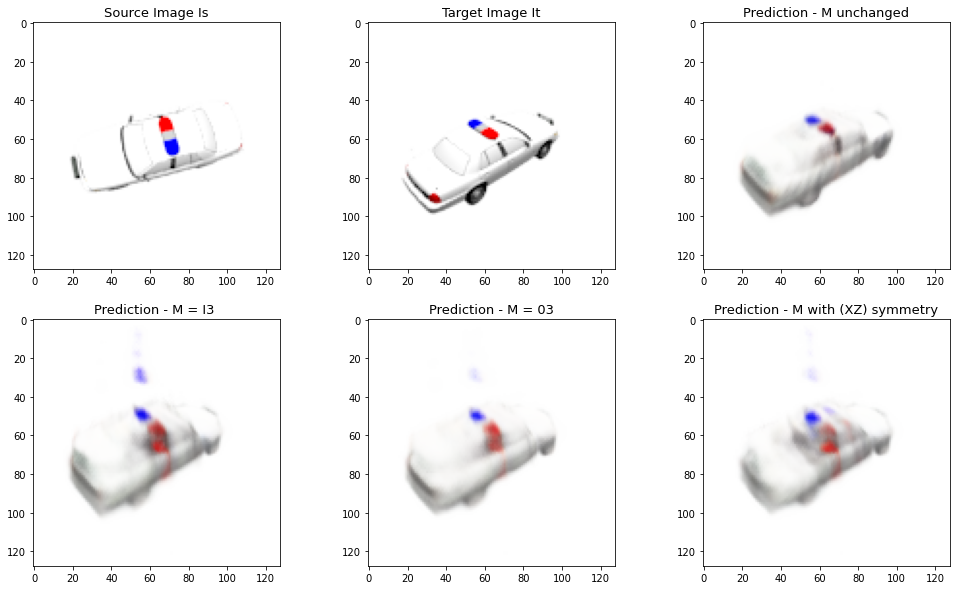


        psnr original: 21.88dB, psnr M = I3: 20.43dB, psnr M = 03: 21.46dB, psnr M with (XZ) symmetry: 20.75dB
        ssim original: 0.88,    ssim M = I3: 0.84,    ssim M = 03: 0.85,    ssim M with (XZ) symmetry: 0.85
        lpips original: 0.125,  lpips M = I3: 0.172,  lpips M = 03: 0.148,  lpips M with (XZ) symmetry: 0.157


In [114]:
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(17, 10))

font = cv2.FONT_HERSHEY_SIMPLEX # font
org = (10, 10)
fontScale = .2
color = (0, 0, 0)
thickness = 1
   

ax1.imshow(Is_np)
ax2.imshow(It)
ax3.imshow(list_res[0]['It_pred'])
ax4.imshow(list_res[1]['It_pred'])
ax5.imshow(list_res[2]['It_pred'])
ax6.imshow(list_res[3]['It_pred'])

ax1.set_title('Source Image Is', fontsize=13)
ax2.set_title('Target Image It', fontsize=13)
ax3.set_title('Prediction - M unchanged', fontsize=13)
ax4.set_title('Prediction - M = I3 ', fontsize=13)
ax5.set_title('Prediction - M = 03', fontsize=13)
ax6.set_title('Prediction - M with (XZ) symmetry', fontsize=13)

plt.show()

### Metric
psnrs = [list_res[i]['psnr'] for i in range(4)]
ssims = [list_res[i]['ssim'] for i in range(4)]
lpipss = [list_res[i]['lpips'] for i in range(4)]


print(f'''
        =====================================================================================================
        psnr original: {psnrs[0]}dB, psnr M = I3: {psnrs[1]}dB, psnr M = 03: {psnrs[2]}dB, psnr M with (XZ) symmetry: {psnrs[3]}dB
        ssim original: {ssims[0]:.2f},    ssim M = I3: {ssims[1]:.2f},    ssim M = 03: {ssims[2]:.2f},    ssim M with (XZ) symmetry: {ssims[3]:.2f}
        lpips original: {lpipss[0]},  lpips M = I3: {lpipss[1]},  lpips M = 03: {lpipss[2]},  lpips M with (XZ) symmetry: {lpipss[3]}
        =====================================================================================================''')

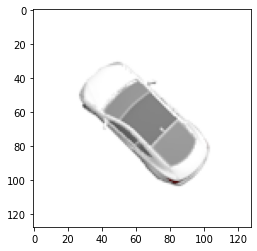

In [60]:
img = cv2.imread('/data/datasets/srn_cars/cars_test/1079efee042629d4ce28f0f1b509eda/rgb/000201.png')[:,:,::-1]
plt.figure()
plt.imshow(img)
plt.show()